# 0 Introduction to RL

本讲内容十分有趣，我们以一个完全没有学习过RL的初学者的视角来看RL问题，并自然地引入许多常见的RL算法。尽管这里并不会详细介绍细节（细节会在后面的讲内部介绍），但是会建立起对这些算法的直观理解。

**什么是RL?**

> Reinforcement learning (RL) is an **interdisciplinary area** of **machine learning** and **optimal control** concerned with how an intelligent agent **ought to take actions** in a **dynamic environment** in order to **maximize the cumulative reward**. Reinforcement learning is one of three basic machine learning paradigms, alongside supervised learning and unsupervised learning. (Wikipedia)

简单来说，RL就是一个研究 **如何在和环境交互中最大化自己的利益，或者“reward”** 的学科。RL中重要的元素是**agent**和**environment**，二者形成一个闭环：
- agent的输入是environment的反馈，输出它的应对，一般称为**action**；
- environment接收agent的反应，并进行一个演化。演化结果给出新的 **状态(state)** 。此外，为了给予agent一个目标，环境还要给agent一个**reward**。

换句话说，agent在每一个state下面给出action，而环境根据这个action就会到达一个新的state。而agent的整体目标，如上所述，是 **最大化reward的时间和**。

![](./assets/0-1.png)

## 0.1 Life is a MDP

### MDP

在介绍RL的基本概念之前，我们首先要介绍MDP的概念。MDP是**Markov Decision Process**的缩写，是强化学习的基础。

一个MDP包括：
- 一个状态空间(state space) $S$
- 一个动作空间(action space) $A$
- 一个奖励函数(reward function) $r$
    - 具体地，对于一个state $s\in S$和一个action $a\in A$，这一函数给出一个实数 $r(s,a)$，代表着在state $s$下面采取action $a$获得的“奖励”。
- 一个状态转移函数(transition function) $p$
    - 具体地，对于一个state $s\in S$和一个action $a\in A$，这一函数给出一个概率分布$p(s'|s,a)$，代表着在state $s$下面采取action $a$之后，下一个state是$s'$的概率。


这里的“Markov”体现在哪里呢？我们可以设想一个agent在和环境逐渐地交互：
- agent初始时处于一个state $s_0$,这是环境给定的；
- agent根据$s_0$采取一个action $a_0$；
- 环境根据$s_0$和$a_0$给出一个reward $r_0$，并且给出下一个state $s_1$。此时，agent就处于state $s_1$；
- agent再根据$s_1$采取一个action $a_1$。不断由此往复……

可以看到，在这一过程中，只要第$t$轮的$s_t,a_t$给定了，环境就可以决定$s_{t+1}$，而不需要$s_0,a_0,s_1,\cdots,s_{t-1},a_{t-1}$这些信息！这就是Markov性质的体现。

那么，“Decision”又是指什么呢？可以看到，上面的描述只包含了环境的部分；而我们的agent的介入方式也很简单，就是对于一个state $s$，给出一个**政策** (policy)，也就是action的分布。我们可以把它记作$\pi(a|s)$。

> Q: 为什么政策只需要当前的state就可以做出决定呢？和历史一定无关吗？
>
> A: 这是也是因为我们Markov的假设。你说的这种情况叫做“Non-markovian agent”。虽然这更普遍，但很多经验表明，non-markovian的agent并不比我们这样的agent做的好很多。

### POMDP

POMDP是Partially Observed MDP的简称。这对应一个虽然略复杂，但更普适的问题陈述：环境并不一定向我们完全袒露心怀，而是只给我们一部分信息。这样的问题在实际中更为常见。比如说，在物理的控制问题中，我们获得一张快照时，就丧失了作为物理系统的state所必须的速度信息。

对于POMDP，我们的policy就不能再是state的函数了。我们后面介绍POMDP的问题的时候也会提到，有两种类型的policy:

- memoryless: $\pi(a_t|o_t)$
- history-dependent: $\pi(a_t|o_1,o_2,\cdots,o_t)$

对于前者，我们有一个形象的图来展示：

![](../lecture/notes/assets/2-1.png)

这里的箭头代表着依赖关系，比如$o_t$依赖于且仅依赖于$s_t$。这样的问题就更加复杂了，因为observation本身不是markovian的——$o_t$不仅依赖于$o_{t-1},a_{t-1}$，而且依赖于$o_{t-2},a_{t-2},\cdots,o_1,a_1$。

在接下来的讨论中，如果不加说明，我们都考虑fully observed的MDP。

### Experiment: MDP Simulators

MDP是一个如此广泛的概念，以至于大部分生活中的问题，在合适地定义state后，都可以变成一个在MDP中最大化cumulative reward的问题。正因如此，**RL基本上就是研究求解MDP的学科**。

但是，在研究RL时，如果真的要和环境进行交互，可能会有很大的代价（想一想为什么？）为此，OpenAI 的 `gym` 包创造了许多模拟环境，供人们“刷分”，也就是把RL算法投入真正应用前先看一看大体上这一方法好不好。我们接下来来看一下gym的使用。

> gym就是一坨答辨。 ——某学长

gym以它的不稳定和不兼容著称，而其渲染部分则是更符合这一描述。因此，在下面的代码开始前，让我们：
- 安装[requirements.txt](./requirements.txt)内的包；
- 运行`bash install.sh`；
- 如果在下面的代码的运行中，你遇到和渲染相关的错误，请不要贸然相信GPT或copilot给你的命令，因为它们有可能会让你的图形界面崩溃，或者显卡驱动失效。建议在各种论坛网站上找一些解决方案。
- 如果你奋斗了很久还是看不到图片，建议你不要再尝试了，而是把所有含有`render`相关的代码注释掉，并观察后面的输出。在之后一般情况下，我们都不会用到渲染。
- 最后，祈祷！

In [1]:
%matplotlib inline
"Gym, I cry out to You; make haste to me! Give output to my code when I cry out to You. Let my library be set before You as binaries, the lifting up of my hands as drivers for graphics." and 'Good luck!'

'Good luck!'

Initial observation: [ 0.0273956  -0.00611216  0.03585979  0.0197368 ]
Initial info: {}


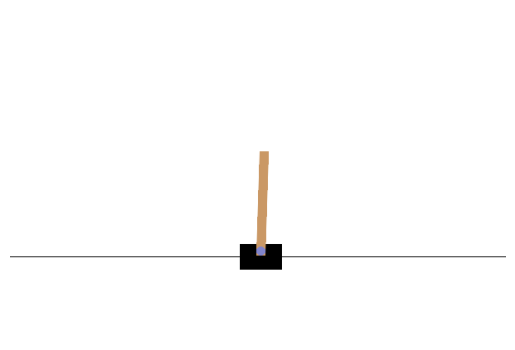

In [2]:
import gymnasium as gym
from utils import show_image
# Create the CartPole environment with 'rgb_array' mode
env = gym.make('CartPole-v1', render_mode='rgb_array')

# Reset the environment
state,info = env.reset(seed=42)
print('Initial state:',state)
print('Initial info:',info)

# Render the environment and display the image
image = env.render()
show_image(image)

如果你成功看到了上面的输出和图片，那么恭喜你，你看到了环境`env`在初始化时的state $s_0$。根据gym的[官方文档](https://gymnasium.farama.org/environments/classic_control/cart_pole/)，这一环境的名字叫做`CartPole`，描述的是一个匀质杆一段铰接在一个置于光滑导轨的小车上。我们看到的`Initial state`中这四个参数的含义如下：
- Cart Position
- Cart Velocity
- Pole Angle
- Pole Angular Velocity

（注：`gym`包中管这个state叫做`observation`，比如`env.observation_space`实际上是state space的意思）。上面的结果是决定性的，因为我们手动设置了`seed`为42。接下来，让我们再看看action是什么：

In [3]:
env.action_space.seed(42)
env.observation_space.seed(42)
'action space',[env.action_space.sample() for _ in range(10)]

('action space',
 [np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(0)])

根据官方文档，0代表向左推一下车，而1代表向右推一下。那么，假设对于初始的状态，我们连续地向右推，会变成什么样？

In [4]:
from utils import show_video
import numpy as np
frames = []
for t in range(100):
    image = env.render()
    frames.append(image)

    action = np.int64(1) # always take the "push right" action.
    next_state, reward, done, truncated, info = env.step(action) # 'step' is the function that gives the transition.
    state = next_state
    print('time stamp',t,'reward:',reward)
    if done or truncated:
        print('Stopped at timestamp',t,'due to','done' if done else 'truncated')
        break

show_video(frames)

time stamp 0 reward: 1.0
time stamp 1 reward: 1.0
time stamp 2 reward: 1.0
time stamp 3 reward: 1.0
time stamp 4 reward: 1.0
time stamp 5 reward: 1.0
time stamp 6 reward: 1.0
time stamp 7 reward: 1.0
time stamp 8 reward: 1.0
time stamp 9 reward: 1.0
Stopped at timestamp 9 due to done


很直观——如果我们一直推这一个车，杆就会向左倒下。此时，因为杆和竖直方向的夹角达到了某个临界值，`env`自动判断为游戏失败而结束。这就是`done`为`True`的原因。

同时，我们也可以看到`reward`的数值——对于每一个存活下来的一步，reward都是1。也就是说，我们的目的就是活得越长越好。

最后，让我们建立一个简单的agent，对这一任务作出一个难度上的基础感受。我们的`TrivialAgent`的思路很简单——如果杆偏左并且角速度向左，那么我们就往左推车；如果杆偏右并且角速度向右，那么我们就往右推车。最后，对于其他情况，因为这取决于未知的物理参数，我们不妨随机来选取action。这十分粗暴，但不妨让我们就看看它能做得怎样。

In [5]:
class TrivialAgent:

    def __init__(self,action_space):
        self.action_space = action_space
    
    def get_action(self,state):
        _,_,theta,omg = state
        if theta < 0 and omg < 0:
            return 0
        if theta > 0 and omg > 0:
            return 1
        return self.action_space.sample()

In [6]:
agent = TrivialAgent(env.action_space)
NUM_ROLLOUTS = 10
results = []
for rollout in range(NUM_ROLLOUTS):
    cum_reward = 0
    state,_ = env.reset()
    for t in range(1000):
        action = agent.get_action(state) # let our agent to decide what to do
        next_state, reward, done, truncated, info = env.step(action)
        state = next_state
        cum_reward += reward
        if done or truncated:
            print('Terminate at time',t,'due to', 'done' if done else 'truncated')
            results.append(cum_reward)
            break
print('Average cumulative reward',sum(results)/len(results))
print('results:',results)

Terminate at time 499 due to truncated
Terminate at time 499 due to truncated
Terminate at time 347 due to done
Terminate at time 412 due to done
Terminate at time 395 due to done
Terminate at time 482 due to done
Terminate at time 499 due to truncated
Terminate at time 249 due to done
Terminate at time 499 due to truncated
Terminate at time 310 due to done
Average cumulative reward 420.1
results: [500.0, 500.0, 348.0, 413.0, 396.0, 483.0, 500.0, 250.0, 500.0, 311.0]


利用`TrivialAgent`，我们解锁了一个新“技能”——`truncated`！这个情况是因为环境具有一个有限的“**horizon**”，也就是到达这个时间后就会自动结束，类似于“游戏胜利”。这样，总的cumulative reward才有上限。我们看到，就这样一个愚蠢的agent就已经可以做到84%的最优解了！因此，这一任务确实是简单的。

我们还可以看到，不同组数据之间reward（即存活时间）可以相差很远——最大值是最小值的2倍！的确，你开始认识到RL了——一个接着一个的state迭代使得整个体系具有**巨大的方差**。我们后面会更加具体地讨论这一点。

最后，让我们欣赏一下我们的第一个“agent”的舞蹈，来结束这一小节吧！

Stopped at timestamp 499 due to truncated


KeyboardInterrupt: 

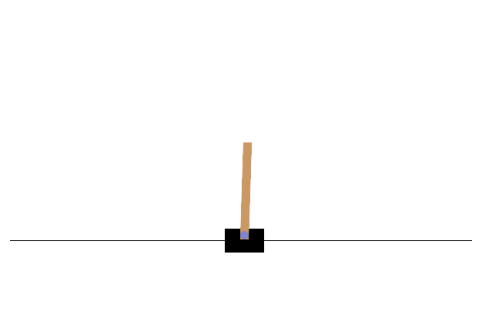

In [7]:
frames = []
[env.reset() for _ in range(2)] # a tiny trick here :)
observation,_ = env.reset()
for t in range(1000):
    image = env.render()
    frames.append(image)

    action = agent.get_action(observation)
    next_state, reward, done, truncated, info = env.step(action)
    observation = next_state
    if done or truncated:
        print('Stopped at timestamp',t,'due to','done' if done else 'truncated')
        break

show_video(frames)

## 0.2 MDP Solvers

有一种非常启发性的讨论RL问题的方法：我们从简单到难，逐渐引出RL的各种方法。现在，就让我们来这样做。

### Values

注意前面的问题中（从`gym`的演示中也可以看到），环境的transition function和reward function都是完全未知的。但考虑到我们对MDP问题还没有太多的了解，我们不妨放松一步，观察一下如果这些函数都是**已知的**，我们**作为一个人**该如何找到最好的策略呢？

这可能说起来略微抽象，但我们可以考虑如下的具体问题：在一个$4\times 4$的方格表里有一个特殊的格子，到达那里时游戏结束并且获得奖励5，而其他地方的奖励都是-1（为了督促你尽快到达终点而非随机乱走）。transition也很简单：在每一个格子(state)处，可以选择向一个方向走(action)，然后就走到了下一个state。（如果在终点那么不管如何走都到达end state）。

注意根据我们的假设，这个MDP是已知的，也就是我们知道那个特殊的格子在哪里。此时，如果不是agent而是人来解决这一问题，你该如何解决？很明显，你可以给出一个决定性的最优策略：假设我们在那个格子旁边的时候，我们就走过去；进一步，如果在再旁边一点的8个格子处，我们就走到前一次的4个格子……这样，递归地，如果确定了距离格子的Manhattan distance (定义为 $\text{MHT}((x_1,y_1),(x_2,y_2))=|x_1-x_2|+|y_1-y_2|$)为$n$的所有点的策略，那么距离格子为$n+1$的所有点的策略也就确定了。因此，我们可以给出一个完整的策略。给定一个具体的 $4\times 4$ 表格和那个特殊的格子，我们就可以给出这个最优策略。一个例子如下所示。

|$\rightarrow$ | $\rightarrow$ | $\downarrow$ | $\leftarrow$|
|--|--|--|--|
| $\rightarrow$| $\to$ | $\star$ | $\leftarrow$ |
|$\rightarrow$ | $\rightarrow$ | $\uparrow$ | $\leftarrow$ |
| $\rightarrow$| $\uparrow$ | $\uparrow$ | $\leftarrow$|

解决了这一问题，我们接下来试着把问题稍微一般化。假设transition并非像上面一样是确定的，而是**随机的**：在一个格子处向上走，只有70%的概率会真正走到上边——剩下的30%里，会随机走到周围剩余的格子里。注意这才是常态，因为我们在定义MDP的时候给出的就是transition probability $p(s'|s,a)$ 而非一个决定性的函数。我们接下来就来试着求解这一问题。

#### Value Iteration

那么，这样我们应该怎么办呢？容易想到，我们可以和上面完全类似地使用一种**递推关系**的方法解决这一问题。我们首先假设我们处于**最优的策略**；接下来，我们给每一个格子定义一个**价值**(value)，代表着如果我们是从这个格子出发，那么最好能达到多少分。很明显，我们有 $V(s_{\star})=5$，其中$s_\star$代表那个特殊的格子。而对于其他格子，我们则要试着把它的价值和周围几个格子的价值联系起来。

||B| | |
|--|--|--|--|
|C| A | $\star$ | |
| | D| |  |
| | | | |

让我们以格子$A$为例来研究。我们虽然不知道最优策略是什么，但是我们总可以假设他的一般形式：

$$
\pi^\star(a|s_A)=\begin{cases}\rightarrow&,\text{w.p. }p_1 \\\leftarrow&,\text{w.p. }p_2 \\ \uparrow&,\text{w.p. }p_3 \\ \downarrow&,\text{w.p. }p_4\end{cases}
$$

其中$\pi^\star$的$\star$代表这是最优策略。那么，我们就可以根据MDP和$V$的定义写出$V(A)$的表达式：

$$
\begin{align*}
V(s_A)&=p_1\left[-1+(70\%\times V(s_{\star})+10\%\times V(s_B)+10\%\times V(s_C)+10\%\times V(s_D))\right]\\
&\quad +p_2\left[-1+(70\%\times V(s_C)+10\%\times V(s_\star)+10\%\times V(s_B)+10\%\times V(s_D))\right]\\
&\quad +p_3\left[-1+(70\%\times V(s_B)+10\%\times V(s_\star)+10\%\times V(s_C)+10\%\times V(s_D))\right]\\
&\quad +p_4\left[-1+(70\%\times V(s_D)+10\%\times V(s_B)+10\%\times V(s_\star)+10\%\times V(s_C))\right]
\end{align*}
$$

但是我们又注意到$\pi^\star$是最优策略，因为这是我们的假设！因此，我们就可以“确定”下来$p_1,p_2,p_3,p_4$：一定是中括号里最大的那个action具有100%的概率，而其他都是0%概率。因此，我们就给出了：

$$
V(s_A)=-1+\max\Big\{70\%\times V(s_{\star})+10\%\times V(s_B)+10\%\times V(s_C)+10\%\times V(s_D),70\%\times V(s_C)+10\%\times V(s_\star)+10\%\times V(s_B)+10\%\times V(s_D), \\ 70\%\times V(s_B)+10\%\times V(s_\star)+10\%\times V(s_C)+10\%\times V(s_D), 70\%\times V(s_D)+10\%\times V(s_B)+10\%\times V(s_\star)+10\%\times V(s_C)\Big\}
$$

类似地，对于其他的每一个格子，我们都可以列出这样的一个方程。16个方程16个未知数，理论上一定可以求解；但是一系列max的存在使得这个问题变得有些复杂。一个投机取巧的方式是说，假设我们并不是直接求解，而是通过“赋值”的方式来近似求解呢？这就是**Value Iteration**算法的基本思想——看，你已经接触到了第一个RL算法！

让我们总结一下，并把上面的讨论一般化。我们给出**Value Iteration**：

> **Value Iteration Algorithm**

1. Init values $V(s)$ randomly for each state.
2. Repeat until convergence:
    - For each state $s$:
        - Update $V(s)$ by
        $$
        V(s)\leftarrow r(s,a)+\max_{a\in A}\mathbb{E}_{s'\sim p(s'|s,a)}[V(s')]
        $$

接下来，让我们就来把这一算法应用到上面提出的问题中吧！（为了使得代码简洁一些，我们把一些细节的内容放到了[utils_0_intro.py](./utils_0_intro.py)里面）

In [1]:
from utils_0_intro import Table
from utils import add_method_to_class

@add_method_to_class(Table)
def iteration(self:Table):
    """
    Perform the Value Iteration algorithm above for one step, and update `self.V`.
    """
    new_V = [[0]*self.size for _ in range(self.size)]
    for i in range(self.size):
        for j in range(self.size):
            if (i,j) == self.special:
                new_V[i][j] = 5
                continue
            l = []
            for action in self.get_possible_action((i,j)):
                weights = self.get_transition((i,j),action)
                l.append(sum([w*self.V[x][y] for (x,y),w in weights.items()]))
            new_V[i][j] = -1 + max(l) # The formula above
    self.V = new_V

t = Table()
t.display()

|0.00|0.00|0.00|0.00|
|-|-|-|-|
|0.00|0.00|0.00|0.00|
|0.00|0.00|0.00|0.00|
|0.00|0.00|0.00|0.00|

In [2]:
for time in range(21):
    t.iteration()
    if time % 5 == 0:
        print('Iteration',time)
        t.display()

Iteration 0


|-1.00|-1.00|-1.00|-1.00|
|-|-|-|-|
|-1.00|-1.00|5.00|-1.00|
|-1.00|-1.00|-1.00|-1.00|
|-1.00|-1.00|-1.00|-1.00|

Iteration 5


|0.02|1.07|2.95|1.66|
|-|-|-|-|
|0.30|2.76|5.00|2.95|
|-0.67|0.61|2.76|1.07|
|-2.74|-0.67|0.30|0.02|

Iteration 10


|0.36|1.62|3.03|2.04|
|-|-|-|-|
|1.04|2.86|5.00|3.03|
|-0.28|1.26|2.86|1.62|
|-1.22|-0.28|1.04|0.36|

Iteration 15


|0.47|1.64|3.05|2.05|
|-|-|-|-|
|1.08|2.90|5.00|3.05|
|-0.10|1.29|2.90|1.64|
|-1.13|-0.10|1.08|0.47|

Iteration 20


|0.48|1.65|3.05|2.06|
|-|-|-|-|
|1.09|2.90|5.00|3.05|
|-0.09|1.31|2.90|1.65|
|-1.09|-0.09|1.09|0.48|

可以发现，这个算法很快就收敛了！的确——在后面的讲中，我们会论证这一算法的收敛性。但接下来，有了这些value，我们应该如何计算我们需要的最优policy呢（还记得我们一开始假设自己处于最优policy，但求解的目标实际上是找到这个policy）？这其实也很简单，因为我们已经得到了结论，我们的action一定是最大化reward $r(s,a)$ 和next value $V(s')$ 的期望值的和。

这一过程也被称为**Policy Extraction**：

$$
\pi^\star(a|s)=\delta\left(a=\arg\max_{a\in A}\left(r(s,a)+\mathbb{E}_{s'\sim p(s'|s,a)}[V(s')]\right)\right)
$$

其中$\delta$代表单点分布。

让我们实现这一点：

In [3]:
@add_method_to_class(Table)
def extract_action(self:Table):
    self.action = [[None]*self.size for _ in range(self.size)]
    for i in range(self.size):
        for j in range(self.size):
            if (i,j) == self.special:
                self.action[i][j] = '\\star'
                continue
            best_act = None
            best_val = -float('inf')
            for action in self.get_possible_action((i,j)):
                weights = self.get_transition((i,j),action)
                new_val = -1 + sum([w*self.V[x][y] for (x,y),w in weights.items()])
                if new_val > best_val:
                    best_val = new_val
                    best_act = action
            self.action[i][j] = self.get_display_str(best_act)

t.extract_action()
t.display(display_type='action')

|$\rightarrow$|$\rightarrow$|$\downarrow$|$\downarrow$|
|-|-|-|-|
|$\rightarrow$|$\rightarrow$|$\star$|$\leftarrow$|
|$\rightarrow$|$\uparrow$|$\uparrow$|$\uparrow$|
|$\uparrow$|$\uparrow$|$\uparrow$|$\uparrow$|

我们可以看到，这确实像是一个最优的策略。至此，我们就完成了Value Iteration方法的讨论，并第一次完整地解决了一个已知MDP下的问题！

#### What about a larger MDP?

上面的方法很直观，并且也很实用。但是，好景不长——在上面的问题里，state space的大小是16。但如果你的梦想是像Alpha Go一样处理围棋，你常见的state space可能是超过$10^{100}$以上！对于这样庞大的state space，就算在宇宙中的每一粒原子上都写下一个value，也不够储存。更为甚者，如果我们处理像之前CartPole一样的问题，我们的state是连续的，就更是无从下手了。

但当我们想到这里的时候，我们一下子就发现了——我们可以使用DL中的技术，**用一个神经网络近似$V(s)$** ！这个网络输入$s$，输出对应的value。考虑到神经网络的“压缩”作用（想想ChatGPT这一模型的大小肯定比它的训练数据加起来小很多倍！），我们就可以处理大规模的MDP问题了。上面的算法中不需要修改任何地方——只需要在更新的时候把赋值换为梯度下降就可以了。（当然，如果具体实现起来可能有很多细节，比如为了避免直接训练这样`batch=1`的不稳定，我们需要采集很多数据再做一波训练，等等）

但敏锐的你可能会发现其中的漏洞：神经网络的拟合本身会带来一个误差。此时，如果依然采用迭代的方法，我们真的还能保证收敛吗？残酷的现实是：**不**。这样的方法（也称为**fitted Value iteration**）并没有一个收敛的保证。实际上，它们不仅理论上不收敛，在实验上也展现着很大的方差。

#### Experiment: Pixel Game

我们可以再实操一个例子：“玩像素”（Pixel Game）。我们有一个$10\times 10$的方格表，其中有22个棋子（也就是“像素”）是我们可以操控的。我们希望这些像素排成一个指定的汉字："**兵**"。

一开始，我们的所有棋子随机排布；而对于每一个state，我们可以采取一个action $(x,y,d)$，其中$(x,y)$代表需要移动的棋子的位置（如果没有棋子那么无效）；而$d$和之前一样是0,1,2,3中的一个，代表上下左右移动（如果无法移动那么也无效）。为了简化问题，我们认为transition是确定的，就是按照方向$d$移动$(x,y)$处的棋子后的整个像素排布。最后，reward $r(s,a)$ 取为只和$s$有关。假设$s$和最终target image的共同像素数（不计算重数）是$N$，那么

$$
r(s,a)=\begin{cases}\frac{N-22}{220}&,N<22\\100&,N=22\end{cases}
$$


In [3]:
from utils_0_intro import PixelGame
from utils import add_method_to_class
pgame = PixelGame()
print('Target image:')
pgame.display_target()
print('Our initial state:')
pgame.display(pgame.reset(randomly=True))
print('Initial reward',pgame.get_reward())

Target image:


| | | | | | | | | | |
|-|-|-|-|-|-|-|-|-|-|
| | | | | |█| | | | |
| | | | |█| | | | | |
| | | |█| | | | | | |
| | | |█|█|█|█|█| | |
| | | |█| |█| | | | |
| |█|█|█|█|█|█|█|█| |
| | | |█| |█| | | | |
| | |█| | | |█| | | |
| | | | | | | | | | |

Our initial state:


|█| |█| | | | | |█| |
|-|-|-|-|-|-|-|-|-|-|
| | | | | | | | | |█|
| |█|█| | | | |█| | |
| | | | | | | | | | |
| | |█| | | | | | | |
|█| | | |█| | | |█| |
| | | |█|█| | |█| |█|
| | | |█| | | | | | |
|█| | | | | | | | |█|
| | | | | | | | | | |

Initial reward -0.08181818181818182


接下来，我们就来设计一个简单的网络$V(s)$。

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader,Dataset

class Net(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=64,kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=64,out_channels=16,kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=16,out_channels=8,kernel_size=3)
        self.mlp = nn.Linear(128,1)

    def forward(self,x):
        """
        compute the estimated Value given state `x`.
        """
        x = nn.LeakyReLU(0.1)(self.conv1(x))
        x = nn.LeakyReLU(0.1)(self.conv2(x))
        x = nn.LeakyReLU(0.1)(self.conv3(x))
        x = x.reshape(x.shape[0],-1)
        return self.mlp(x)

接下来，我们来准备训练数据。回顾一下我们的训练过程是

$$
V(s)\leftarrow \max_{a\in A}\left(r(s,a)+\mathbb{E}_{s'\sim p(s'|s,a)}[V(s')]\right)
$$

这里唯一的变量是$s$。对于哪些$s$做这一更新呢？可以对于所有$s$，但这不现实——这一问题的state space大小是$10^{30}$左右的量级。我们为了充分利用fitted value iteration的优势，我们必须只选取相对少的一些state来训练。

那如何选取这些state呢？我们发现，这些state要**具有代表性**。比如最极端地，如果没有任何一个state有着非零的reward，我们的网络就不可能学到任何东西。因此，我们决定根据他们的**分数**（也就是和目标图案重复的pixel个数）来选取数据。

In [5]:
import random

@add_method_to_class(PixelGame)
def sample_given_score(self:PixelGame,match_num,sample_num=200):
    """
    Sample some states given `match_num`.

    Args:
        `match_num`: the number of states that match the target image.
        `sample_num`: the number of states to sample.
    """
    other_pixels = [(i,j) for i in range(10) for j in range(10) if (i,j) not in self.target_pixel_pos]
    states = []
    for _ in range(sample_num):
        common = random.sample(self.target_pixel_pos,match_num)
        others = random.choices(other_pixels,k=22-match_num)
        states.append(common + others)
    return states

states = []
for match_num in range(23):
    states.extend(pgame.sample_given_score(match_num=match_num))
print('Gathered states:',len(states))

Gathered states: 4600


接下来，我们考虑训练过程。回顾一下，最外围的循环是Value iteration，就像之前那样；而和之前不同的是，我们在内部又添加了一个神经网络拟合的循环。

一个必须讨论的细节是，为了发挥optimizer的优势，我们应该不是一组一组数据训练，而是把训练数据收集起来并用batch来训练。为此，我们编写一个函数`get_dataloader`。

In [6]:
# first load the transitions once
print('Storing transitions, this may take around a minute...')
transition_datas = []
for state in states:
    actions = pgame.get_actions(state)
    nexts = []
    terminated = False
    for action in actions:
        next_state = pgame.get_transition(state,action)
        if next_state is None:
            terminated = True
            break
        nexts.append(pgame.as_tensor(next_state))
    transition_datas.append({
        'state':state,
        'next_states':torch.stack(nexts,dim=0) if not terminated else None,
        'terminated':terminated
    })
len(transition_datas)

Storing transitions, this may take around a minute...


4600

In [7]:
from utils import device

@torch.no_grad()
def get_dataloader(net:Net):
    dataset = []
    for it in transition_datas:
        state = it['state']
        target = pgame.get_reward(state)
        term = it['terminated']
        if not term:
            target += net(it['next_states'].to(device)).max(dim=0)[0].cpu().item()
        dataset.append((state,target))
    return DataLoader(dataset=dataset,batch_size=128,shuffle=True,
    collate_fn=lambda datas:
        {
            'states': torch.stack([pgame.as_tensor(data[0]) for data in datas],dim=0),
            'targets':torch.tensor([data[1] for data in datas],dtype=torch.float).unsqueeze(-1)
        }
    )

注意，这里的`terminated`变量处理了一个特殊情况：如果已经到了最终的state $s_\star$，那么没有下一个transition，而且value的训练目标就是$r(s_\star)=100$。

最后，我们可以开始了！

In [8]:
pick_state = states[len(states)//2] # here we select a state to monitor the convergence of value iteration.
values_for_that_state = []
print('We use this random state to monitor the value:')
pgame.display(pick_state)

We use this random state to monitor the value:


| | | | |█| | | | | |
|-|-|-|-|-|-|-|-|-|-|
|█|█| | | |█| | | | |
| | |█| | | | | | | |
| | | |█| | | | | | |
| | | |█|█| |█| | | |
| | | |█|█| |█| | | |
|█| |█| |█| |█|█|█| |
| |█| | | | | | | | |
| | | | | |█| | | | |
| | | | | | | | |█| |

In [57]:
from tqdm import tqdm
net = Net().to(device)
opt = Adam(net.parameters(),lr=5e-3)
values_for_that_state = []
for iteration in range(25):
    losses = []
    dataloader = get_dataloader(net)
    with tqdm(dataloader) as bar:
        for it in bar:
            val = net(it['states'].to(device)) # [batch,1]
            loss = F.mse_loss(val,it['targets'])
            opt.zero_grad()
            loss.backward()
            opt.step()
            losses.append(loss.detach().cpu().item())
            bar.set_description(f'Iteration {iteration}: loss {sum(losses)/len(losses):.4f}')
    with torch.no_grad():
        value = net(pgame.as_tensor(pick_state).unsqueeze(0).to(device)).cpu().item()
    if iteration % 5 == 0:
        print('Value of the specific state',value)
    values_for_that_state.append(value)

Iteration 0: loss 378.9311: 100%|██████████| 36/36 [00:01<00:00, 30.80it/s]


Value of the specific state 0.3292299509048462


Iteration 5: loss 6.9925: 100%|██████████| 36/36 [00:01<00:00, 26.57it/s] 


Value of the specific state 22.306779861450195


Iteration 10: loss 11.7262: 100%|██████████| 36/36 [00:01<00:00, 28.60it/s]


Value of the specific state 69.13394927978516


Iteration 15: loss 83.2631: 100%|██████████| 36/36 [00:01<00:00, 26.81it/s] 


Value of the specific state 118.82010650634766


Iteration 20: loss 917.9474: 100%|██████████| 36/36 [00:01<00:00, 28.52it/s] 


Value of the specific state 208.20388793945312


Iteration 24: loss 2916.3315: 100%|██████████| 36/36 [00:01<00:00, 26.68it/s]


我们还可以观察一下整个过程中value整体上是如何变化的：

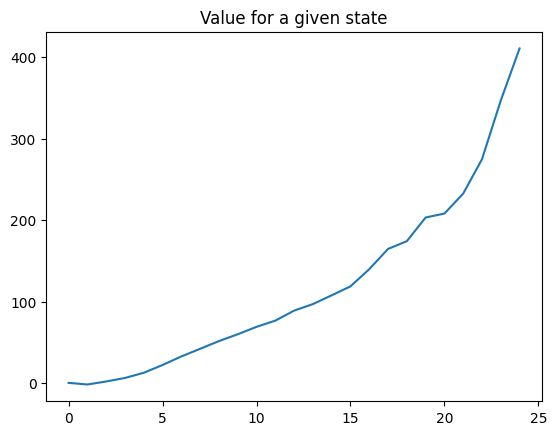

In [58]:
import matplotlib.pyplot as plt
plt.plot([x[0] for x in enumerate(values_for_that_state)],values_for_that_state)
plt.title('Value for a given state')
plt.show()

可以发现，value虽然开始有所涨落，但之后上升的很快。我们再来看看给出的策略如何？

In [9]:
def demonstrate_policy(net):
    state = pgame.reset(randomly=True)
    cum_r = 0
    succeed = False
    print('Initial state:')
    pgame.display()
    print('Initial common pixels',pgame.get_common_pixels(state))
    for time in range(200):
        actions = pgame.get_actions(state)
        best_act = None
        best_val = float('-inf')
        for action in actions:
            next_state = pgame.get_transition(state,action)
            with torch.no_grad():
                value = net(pgame.as_tensor(next_state).unsqueeze(0).to(device)).cpu().item()
            if value > best_val:
                best_val = value
                best_act = action
        cum_r += pgame.get_reward(state)
        state = pgame.get_transition(state,best_act)
        if state is None:
            break
        pgame.set_state(state)
        if time % 20 == 1:
            print('t =',time)
            pgame.display()
    print('Cumulative reward',f'{cum_r:.2f}')
    print('Succeeded?',succeed)
    print('Final common pixels:',100 if succeed else pgame.get_common_pixels(state))
    return state

In [60]:
demonstrate_policy(net)

Initial state:


| |█| |█| | |█| | |█|
|-|-|-|-|-|-|-|-|-|-|
| | |█| | | |█|█| | |
| |█| | | | | | | | |
| |█| | | | | | | | |
| | | | |█| |█|█| | |
| | | | | | | | | | |
| | | |█| | | | | | |
|█| | | | | | | | | |
|█| | | | | |█|█| |█|
| | | | | | | | | | |

Initial common pixels 5
t = 1


| |█| |█| | |█| | |█|
|-|-|-|-|-|-|-|-|-|-|
| | |█| | | |█|█| | |
| | | | | | | | | | |
| |█| | | | | | | | |
| | | | |█| |█| | | |
| | | | | | | | | | |
| | | |█| | | | | | |
|█| | | | | | | | | |
|█| | | | | |█|█| |█|
| | | | | | | | | | |

t = 21


| | |█| | | | | | | |
|-|-|-|-|-|-|-|-|-|-|
| | | |█| | |█| | | |
| | | | | | | | | | |
| |█| | | | | | | | |
| | | | | |█| | | | |
| | | | | | | | | | |
| | | |█| | | | | | |
|█| | | | | | | | | |
| | | | | | | |█| | |
| | | | | | | | | | |

t = 41


| | |█| | | | | | | |
|-|-|-|-|-|-|-|-|-|-|
| | | |█| | |█| | | |
| | | | | | | | | | |
| |█| | | | | | | | |
| | | | | |█| | | | |
| | | | | | | | | | |
| | | |█| | | | | | |
|█| | | | | | | | | |
| | | | | | | |█| | |
| | | | | | | | | | |

t = 61


| | |█| | | | | | | |
|-|-|-|-|-|-|-|-|-|-|
| | | |█| | |█| | | |
| | | | | | | | | | |
| |█| | | | | | | | |
| | | | | |█| | | | |
| | | | | | | | | | |
| | | |█| | | | | | |
|█| | | | | | | | | |
| | | | | | | |█| | |
| | | | | | | | | | |

t = 81


| | |█| | | | | | | |
|-|-|-|-|-|-|-|-|-|-|
| | | |█| | |█| | | |
| | | | | | | | | | |
| |█| | | | | | | | |
| | | | | |█| | | | |
| | | | | | | | | | |
| | | |█| | | | | | |
|█| | | | | | | | | |
| | | | | | | |█| | |
| | | | | | | | | | |

t = 101


| | |█| | | | | | | |
|-|-|-|-|-|-|-|-|-|-|
| | | |█| | |█| | | |
| | | | | | | | | | |
| |█| | | | | | | | |
| | | | | |█| | | | |
| | | | | | | | | | |
| | | |█| | | | | | |
|█| | | | | | | | | |
| | | | | | | |█| | |
| | | | | | | | | | |

t = 121


| | |█| | | | | | | |
|-|-|-|-|-|-|-|-|-|-|
| | | |█| | |█| | | |
| | | | | | | | | | |
| |█| | | | | | | | |
| | | | | |█| | | | |
| | | | | | | | | | |
| | | |█| | | | | | |
|█| | | | | | | | | |
| | | | | | | |█| | |
| | | | | | | | | | |

t = 141


| | |█| | | | | | | |
|-|-|-|-|-|-|-|-|-|-|
| | | |█| | |█| | | |
| | | | | | | | | | |
| |█| | | | | | | | |
| | | | | |█| | | | |
| | | | | | | | | | |
| | | |█| | | | | | |
|█| | | | | | | | | |
| | | | | | | |█| | |
| | | | | | | | | | |

t = 161


| | |█| | | | | | | |
|-|-|-|-|-|-|-|-|-|-|
| | | |█| | |█| | | |
| | | | | | | | | | |
| |█| | | | | | | | |
| | | | | |█| | | | |
| | | | | | | | | | |
| | | |█| | | | | | |
|█| | | | | | | | | |
| | | | | | | |█| | |
| | | | | | | | | | |

t = 181


| | |█| | | | | | | |
|-|-|-|-|-|-|-|-|-|-|
| | | |█| | |█| | | |
| | | | | | | | | | |
| |█| | | | | | | | |
| | | | | |█| | | | |
| | | | | | | | | | |
| | | |█| | | | | | |
|█| | | | | | | | | |
| | | | | | | |█| | |
| | | | | | | | | | |

Cumulative reward -18.08
Succeeded? False
Final common pixels: 2


我们发现我们的网络竟然什么都没有学到——最后的common pixel个数竟然少于一开始的！这显然说明了网络的价值评估出现了错误。再一回味，也又发现了问题：无论如何，value都不应该到达100以上，因为最终的state才有reward 100，而其他的state reward都为负数。一定是有地方出了问题！

哈哈，的确——提出理论只需要凭感觉就可以了，但做实验的人需要想的就多了。我们只能观察：可以发现，**随着value的大幅度上升，loss也增加了**，如何解释这件事呢？

其实，道理很简单——为什么在一个iteration内部我们的loss不能降到0？我们的神经网络表达能力肯定还是够的，真正的问题在于**数据太差**。为什么数据差？原因也很简单，因为value iteration的中间结果可能有一定波动，这些波动在不同的state上体现不一样，而value又间接地被当成训练数据，这就好比是训练数据上下了毒一般。更糟糕的是，这样训练出来的糟糕模型又被当成下一次训练的目标，这样loss就会爆炸一般大幅上升。

一个很好的比喻是说，上面的方法宛如**shooting a moving target**。我们的DL模型之所以强大，是因为他们狠狠地在固定的靶子上训练并达到极高的水准；而现在把他们应用到这里可能令他们有些水土不服。为何不让靶子**停下来**，或者**慢下来**呢？这就是**target network**的基本思想。

#### Target Network

首先，我们引入一个**target network** $V_{\theta_0}$，而把原来的网络叫做$V_\theta$。其次，我们的更新方式就变成了

$$
\theta \leftarrow \theta + \eta \nabla_{\theta}\left[V_\theta(s)-\left(\max_{a\in A}\left(r(s,a)+\mathbb{E}_{s'\sim p(s'|s,a)}[V_{\theta_0}(s')]\right)\right)\right]^2
$$

顾名思义——target network就用于target的计算。回顾之前的方法，相当于target network被取为前一个Iteration更新后的$V$，瞬息万变；而现在，我们希望target network的更新慢一些。

第一个方法就是，我们**隔一段时间猛地更新一下**：

```python
if iteration % PERIOD == 0:
    target_net.load_state_dict(net.state_dict())
```

而第二个方法更加文明：我们每一次使用running average更新。也就是说：

$$
\theta_0 \leftarrow (1-\alpha)\theta_0 + \alpha \theta
$$

这稍微更难实现一些，但更稳定（可以想象），因此我们采用这第二种方法。

In [10]:
from tqdm import tqdm
net = Net().to(device)
target_net = Net().to(device).requires_grad_(False)
target_net.load_state_dict(net.state_dict())
opt = Adam(net.parameters(),lr=5e-3)
values_for_that_state = []
ALPHA = 0.2
def update_target():
    for theta_0,theta in zip(target_net.parameters(),net.parameters()):
        theta_0.copy_((1-ALPHA) * theta_0 + ALPHA * theta)

def continue_train_one(iteration):
    losses = []
    dataloader = get_dataloader(target_net)
    with tqdm(dataloader) as bar:
        for it in bar:
            val = net(it['states'].to(device)) # [batch,1]
            loss = F.mse_loss(val,it['targets'])
            opt.zero_grad()
            loss.backward()
            opt.step()
            losses.append(loss.detach().cpu().item())
            bar.set_description(f'Iteration {iteration}: loss {sum(losses)/len(losses):.4f}')
    update_target()
    with torch.no_grad():
        value = net(pgame.as_tensor(pick_state).unsqueeze(0).to(device)).cpu().item()
    if iteration % 5 == 0:
        print('Value of the specific state',value)
    values_for_that_state.append(value)

for iteration in range(50):
    continue_train_one(iteration)

  0%|          | 0/36 [00:00<?, ?it/s]/home/zhh/anaconda3/envs/DYY/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Iteration 0: loss 376.5416: 100%|██████████| 36/36 [00:03<00:00,  9.13it/s]


Value of the specific state 1.0860837697982788


Iteration 5: loss 103.4360: 100%|██████████| 36/36 [00:02<00:00, 14.65it/s]


Value of the specific state -0.9524780511856079


Iteration 10: loss 20.2123: 100%|██████████| 36/36 [00:02<00:00, 12.95it/s]


Value of the specific state -0.4902338981628418


Iteration 15: loss 8.1547: 100%|██████████| 36/36 [00:01<00:00, 29.53it/s]


Value of the specific state 0.34135037660598755


Iteration 20: loss 5.8066: 100%|██████████| 36/36 [00:01<00:00, 29.46it/s]


Value of the specific state 1.3233623504638672


Iteration 25: loss 6.1928: 100%|██████████| 36/36 [00:01<00:00, 27.70it/s]


Value of the specific state 2.6742236614227295


Iteration 30: loss 4.1624: 100%|██████████| 36/36 [00:01<00:00, 29.34it/s]


Value of the specific state 3.621687650680542


Iteration 35: loss 3.4405: 100%|██████████| 36/36 [00:01<00:00, 27.30it/s]


Value of the specific state 5.300535678863525


Iteration 40: loss 3.2928: 100%|██████████| 36/36 [00:01<00:00, 28.68it/s]


Value of the specific state 7.4809160232543945


Iteration 45: loss 4.1729: 100%|██████████| 36/36 [00:01<00:00, 27.01it/s]


Value of the specific state 10.133275985717773


Iteration 49: loss 2.4073: 100%|██████████| 36/36 [00:01<00:00, 26.88it/s]


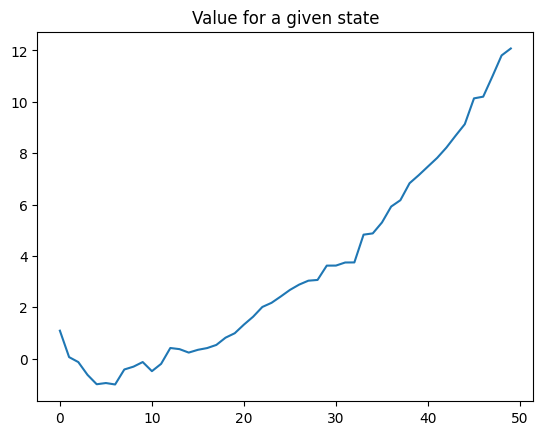

In [13]:
plt.plot([x[0] for x in enumerate(values_for_that_state)],values_for_that_state)
plt.title('Value for a given state')
plt.show()

看起来不错！之前loss随着value增大的逐渐上升现象消失了。让我们继续吧！

当然，看到value一直在上升，我们也要大概心里有个概念：value的理论值大概是多少？上限肯定是100；而下限可以简单地估算：$100-0.1\times (20\times 22)=56$，其中$20\times 22$是最大可能的操作步数。因此，最终的value应该在二者之间才合理。

In [14]:
for iteration in range(50,100):
    continue_train_one(iteration)

Iteration 50: loss 3.7577: 100%|██████████| 36/36 [00:01<00:00, 26.47it/s]


Value of the specific state 12.523367881774902


Iteration 55: loss 2.6643: 100%|██████████| 36/36 [00:01<00:00, 25.00it/s]


Value of the specific state 15.702837944030762


Iteration 60: loss 2.6053: 100%|██████████| 36/36 [00:01<00:00, 26.78it/s]


Value of the specific state 21.097808837890625


Iteration 65: loss 3.1543: 100%|██████████| 36/36 [00:01<00:00, 25.89it/s]


Value of the specific state 27.8411922454834


Iteration 70: loss 4.7544: 100%|██████████| 36/36 [00:01<00:00, 26.35it/s]


Value of the specific state 33.99541473388672


Iteration 75: loss 5.8132: 100%|██████████| 36/36 [00:01<00:00, 26.79it/s]


Value of the specific state 43.052711486816406


Iteration 80: loss 7.4480: 100%|██████████| 36/36 [00:01<00:00, 26.08it/s] 


Value of the specific state 51.855960845947266


Iteration 85: loss 9.8739: 100%|██████████| 36/36 [00:01<00:00, 26.73it/s]


Value of the specific state 59.42119216918945


Iteration 90: loss 15.7185: 100%|██████████| 36/36 [00:01<00:00, 25.49it/s]


Value of the specific state 71.75312805175781


Iteration 95: loss 14.9141: 100%|██████████| 36/36 [00:01<00:00, 23.89it/s]


Value of the specific state 81.4828872680664


Iteration 99: loss 29.1995: 100%|██████████| 36/36 [00:01<00:00, 25.96it/s]


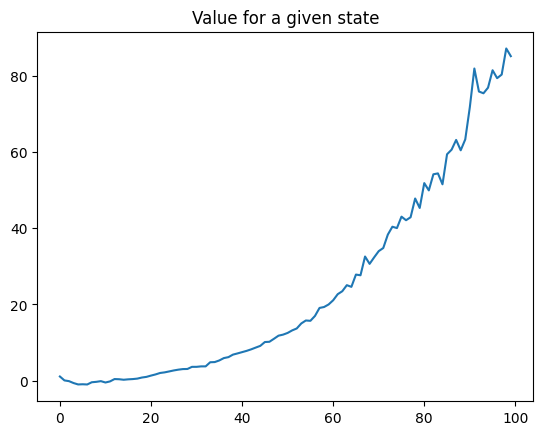

In [15]:
plt.plot([x[0] for x in enumerate(values_for_that_state)],values_for_that_state)
plt.title('Value for a given state')
plt.show()

糟了——就在最后几个iteration里，value又和loss一起起飞了。我们没有从根本上解决这个问题，但不妨先看看效果如何：

In [16]:
last_state = demonstrate_policy(net)

Initial state:


|█| | | | | | |█| | |
|-|-|-|-|-|-|-|-|-|-|
| |█| |█| | |█| | | |
| |█|█| |█| | |█| | |
| | |█| | | |█| | |█|
| | | | | | | | | |█|
| | | | | | | | | | |
| | | | | |█|█| | | |
| |█| | | | |█| | | |
| | | | | | | | | | |
| | | | |█|█| | | | |

Initial common pixels 3
t = 1


|█| | | | | | |█| | |
|-|-|-|-|-|-|-|-|-|-|
| |█| |█| | |█| | | |
| |█|█| |█| | |█| | |
| | |█| | | |█| | |█|
| | | | | | | | | |█|
| | | | | | | | | | |
| | | | | |█| | | | |
| |█| | | |█| | | | |
| | | | | | | | | | |
| | | | |█|█| | | | |

t = 21


|█| | | | | | | | | |
|-|-|-|-|-|-|-|-|-|-|
| | | | |█| |█| | | |
| |█| | | | | | | | |
| | | |█| | | | | |█|
| | | |█|█| | | | |█|
| | | | | |█| | | | |
| | | | | |█| | | | |
| |█| | | | | | | | |
| | | | | | | | | | |
| | | | |█|█| | | | |

t = 41


|█| | | | | | | | | |
|-|-|-|-|-|-|-|-|-|-|
| | | | |█|█|█| | | |
| | | | | | | | | | |
| | | |█| | | | | | |
| | | |█|█|█|█|█| | |
| | | |█| |█| | | | |
| | | | |█| | | | | |
| |█| | | | | | | | |
| | | | | | | | | | |
| | | | |█|█| | | | |

t = 61


| |█| | | | | | | | |
|-|-|-|-|-|-|-|-|-|-|
| | | | | |█|█| | | |
| | | | | | | | | | |
| | | |█| | | | | | |
| | | |█|█|█|█|█| | |
| | | |█| |█| | | | |
| | | | |█| | | | | |
| | | | | | | | | | |
| | | | | | | | | | |
| | | | | |█| | | | |

t = 81


| |█| | | | | | | | |
|-|-|-|-|-|-|-|-|-|-|
| | | | | |█|█| | | |
| | | | | | | | | | |
| | | |█| | | | | | |
| | | |█|█|█|█|█| | |
| | | |█| |█| | | | |
| | | | |█| | | | | |
| | | | | | | | | | |
| | | | | | | | | | |
| | | | | |█| | | | |

t = 101


| |█| | | | | | | | |
|-|-|-|-|-|-|-|-|-|-|
| | | | | |█|█| | | |
| | | | | | | | | | |
| | | |█| | | | | | |
| | | |█|█|█|█|█| | |
| | | |█| |█| | | | |
| | | | |█| | | | | |
| | | | | | | | | | |
| | | | | | | | | | |
| | | | | |█| | | | |

t = 121


| |█| | | | | | | | |
|-|-|-|-|-|-|-|-|-|-|
| | | | | |█|█| | | |
| | | | | | | | | | |
| | | |█| | | | | | |
| | | |█|█|█|█|█| | |
| | | |█| |█| | | | |
| | | | |█| | | | | |
| | | | | | | | | | |
| | | | | | | | | | |
| | | | | |█| | | | |

t = 141


| |█| | | | | | | | |
|-|-|-|-|-|-|-|-|-|-|
| | | | | |█|█| | | |
| | | | | | | | | | |
| | | |█| | | | | | |
| | | |█|█|█|█|█| | |
| | | |█| |█| | | | |
| | | | |█| | | | | |
| | | | | | | | | | |
| | | | | | | | | | |
| | | | | |█| | | | |

t = 161


| |█| | | | | | | | |
|-|-|-|-|-|-|-|-|-|-|
| | | | | |█|█| | | |
| | | | | | | | | | |
| | | |█| | | | | | |
| | | |█|█|█|█|█| | |
| | | |█| |█| | | | |
| | | | |█| | | | | |
| | | | | | | | | | |
| | | | | | | | | | |
| | | | | |█| | | | |

t = 181


| |█| | | | | | | | |
|-|-|-|-|-|-|-|-|-|-|
| | | | | |█|█| | | |
| | | | | | | | | | |
| | | |█| | | | | | |
| | | |█|█|█|█|█| | |
| | | |█| |█| | | | |
| | | | |█| | | | | |
| | | | | | | | | | |
| | | | | | | | | | |
| | | | | |█| | | | |

Cumulative reward -11.78
Succeeded? False
Final common pixels: 10


我们只能说模型还是取得了一定的进步，但还没有排“兵”布阵的能力。但接下来，我们该何去何从呢？

我们可以先以上面的最后一张图片为例子，看看为什么这个过程进行不下去了？

In [18]:
actions = pgame.get_actions(last_state)
lst = []
for a in actions:
    lst.append((a,net(pgame.as_tensor(pgame.get_transition(last_state,a)).unsqueeze(0).to(device)).item()))
print(sorted(lst,reverse=True,key=lambda x: x[1])[:5])

[((0, 1, 1), 328.1156311035156), ((9, 5, 0), 328.1156311035156), ((0, 1, 3), 328.0306396484375), ((9, 5, 2), 327.4559326171875), ((9, 5, 3), 327.331298828125)]


我们发现，无论采取什么样的action，对应的value都很接近！在这样的情况下，模型自身近似造成的误差就已经远大于不同action之间的“区分度”，而在这里模型恰好选择了一个不做任何操作的action，这样他就被“卡住”了。

同时，我们看到Value的数值又是超过了100！的确，神经网络的本质让这没有任何办法——神经网络的输出是十分“凹凸不平”的，就算整体上Value小于100,也肯定有一些奇怪的地方Value非常巨大。在这些地方Value网络的准确度更是完全没法保证。

为了解决这一问题，我们其实可以从根本上反思Value Iteration这一方法：还记得之前我们如何引入Value这一概念的吗？当时我们假设自己处于最优策略，并据此给出每一个点处的“价值”，满足一个递推关系。然后，我们设法求解这个递推关系得到一个Value的近似值。最后，我们再做policy extraction。在这一过程中，Value毕竟只是一个媒介。我们自然地想到：我们是否可以**不经过Value这一层，直接优化policy**呢？

从直觉上，这样非常好——因为policy直接就是我们想要的东西，就没有必要比较不同的Value，神经网络的拟合误差也就不会被放大。这就是Policy-based method的本质性优点，下面我们就来探讨它们。

### Policy-based Methods
